Jupyter Notebook to create a Machine Learning model for the Kaggle Titanic competition 

In [404]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix

# We assume that the data from the Kaggle site (train.csv and test.csv) are stored
# in a folder called datasets.

def load_titanic_data():
    csv_path = os.path.join("datasets", "train.csv")
    return pd.read_csv(csv_path)

def load_titanic_test_data():
    csv_path = os.path.join("datasets", "test.csv")
    return pd.read_csv(csv_path)

def clean_data(titanic):

    # Change the sex from a string to a number
    ordinal_encoder = OrdinalEncoder()
    sex_cat = titanic[["Sex"]]
    sex_enc = ordinal_encoder.fit_transform(sex_cat)
    titanic['Sexenc'] = sex_enc
    titanic.drop('Sex', axis='columns', inplace=True)
    
    # Change embarked to a number
    titanic["Embarked"] = titanic["Embarked"].fillna('S')
    embarked_cat = titanic[['Embarked']]
    embarked_enc = ordinal_encoder.fit_transform(embarked_cat)
    titanic['Embarkedenc'] = embarked_enc
    titanic.drop('Embarked', axis='columns', inplace=True)
    
    # Change the Fare, fill missing values with median
    titanic['Fare'].replace('', np.nan, inplace=True)
    mean = titanic['Fare'].mean() 
    titanic['Fare'].fillna(mean, inplace=True)
    titanic['Fare'] = pd.to_numeric(titanic['Fare'])
    
    titanic = titanic.fillna("")
    # The first letter of the Cabin indicates the deck
    # Extract the Deck from the Cabin and change it to a number
    titanic['Deck'] = titanic['Cabin'].str[:1]
    deck_cat = titanic[['Deck']]
    deck_enc = ordinal_encoder.fit_transform(deck_cat)
    titanic['Deckenc'] = deck_enc
    titanic.drop('Deck', axis='columns', inplace=True)
    titanic.drop('Cabin', axis='columns', inplace=True)
    
    # Fill missing values
    titanic.loc[titanic['PassengerId'] == 631, 'Age'] = 48
    
    # Change the age, fill missing values with median
    titanic['Age'].replace('', np.nan, inplace=True)
    mean = titanic['Age'].mean() 
    titanic['Age'].fillna(mean, inplace=True)
    titanic['Age'] = pd.to_numeric(titanic['Age'])
    
    # Drop columns that don't have a strong correlation with survived
    titanic.drop('SibSp', axis='columns', inplace=True)
    titanic.drop('Parch', axis='columns', inplace=True)
    titanic.drop('Name', axis='columns', inplace=True)
    titanic.drop('Ticket', axis='columns', inplace=True)
    
    titanic.set_index("PassengerId", inplace = True)
    
    return titanic

def removeOutliers(titanic):
    print(titanic.count())
    titanic['Fare'] = removeOutliersFromColumn(titanic, "Fare")
    titanic['Age'] = removeOutliersFromColumn(titanic, "Age")
    return titanic
    
def removeOutliersFromColumn(titanic, column):
    q_low = titanic[column].quantile(0.01)
    q_hi  = titanic[column].quantile(0.99)
    print(f"{q_low} {q_hi}")
    df_filtered = titanic[(titanic[column] < q_hi) & (titanic[column] > q_low)]
    return df_filtered
    
def showCorrelation(titanic):
    corr_matrix = titanic.corr().abs()
    print(corr_matrix['Survived'].sort_values(ascending=False))
    

In [405]:
# Clean the data and remove the outliers
titanic=load_titanic_data()
#disabled removing the outliers as it made the prediction worse 
#titanic = removeOutliers(titanic) 
titanic=clean_data(titanic)
showCorrelation(titanic)



Survived       1.000000
Sexenc         0.543351
Pclass         0.338481
Deckenc        0.287944
Fare           0.257307
Embarkedenc    0.167675
Age            0.073724
Name: Survived, dtype: float64


In [406]:
# Split the training set from Kaggle into a training set and test set 
# to be able to evaluate the performance of the model
y = titanic['Survived'].copy()
titanic.drop('Survived', axis='columns', inplace=True)
X_train, X_test, y_train, y_test = train_test_split(titanic, y, random_state=42)
# Scale the training and test set.
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

# Create and train the SVM
clf_svm = SVC()
clf_svm.fit(X_train_scaled, y_train)

SVC()

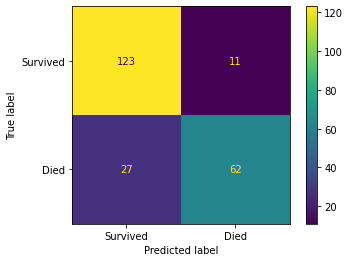

In [407]:
plot_confusion_matrix(clf_svm, X_test_scaled, y_test, 
                      values_format='d', display_labels=['Survived', 'Died'])

In [408]:
titanic_test = load_titanic_test_data()
result_df = pd.DataFrame(titanic_test['PassengerId'].values)
titanic_test = clean_data(titanic_test)
X_test_scaled = scale(titanic_test)

# used the trained model to predict the survival
prediction = pd.DataFrame(clf_svm.predict(X_test_scaled))

# format the result according to the requested format from Kaggle 
result_df['Survived']=prediction
result_df=result_df.rename(columns = {0:'PassengerId'})
result_df.set_index('PassengerId', inplace=True)
# save the result as a CSV file which can be submitted through the Kaggle website
result_df.to_csv("titanic_prediction.csv")